In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
k=3
info = pd.read_csv("iris.data.csv")

In [3]:
def get_train_test_split(df, train_size=0.7):
    test_size = 1 - train_size
    
    #copy 70% of random chosen data as training set
    train = df.sample(
        round(df.shape[0]*train_size)
    ).copy()
    
    test = df.loc[[x for x in df.index if x not in list(train.index)]]
    
#     return X_train, Y_train, X_test, Y_test
    return train, test

In [4]:
train, test = get_train_test_split(info, train_size=0.6)

In [5]:
#makes sure that the points in train dont exist in test
assert(len(set(train.index).intersection(set(test.index))) == 0)

In [6]:
train.head()

,sepalLength,sepalWidth,petalLength,petalWidth,Class
33,5.5,4.2,1.4,0.2,Iris-setosa
23,5.1,3.3,1.7,0.5,Iris-setosa
112,6.8,3.0,5.5,2.1,Iris-virginica
92,5.8,2.6,4.0,1.2,Iris-versicolor
12,4.8,3.0,1.4,0.1,Iris-setosa


In [7]:
train['Class'].value_counts().values

array([34, 33, 23])

In [8]:
def distance(point, cent, ax=1):
    return np.linalg.norm(point - cent, axis=ax)

In [9]:
#assign point to cluster (0, 1, or 2)
def getCentroids(data):
    #initialize training set
    trainSet = data.drop('Class', axis=1).values
    trainGroup = np.zeros(len(trainSet))
    
    #init Centroids
    centroidX = np.random.uniform(trainSet[:, 0].min(), high = trainSet[:, 0].max(), size = k)
    centroidY = np.random.uniform(trainSet[:, 1].min(), high = trainSet[:, 1].max(), size = k)
    centroid = np.array(list(zip(centroidX, centroidY)), dtype = np.float32)
    
    
    #init previous centroid and displacement
    oldCentroid = np.zeros((len(centroid), len(centroid[0])))
    displacement = None
    
    #Clustering
    while displacement is None or np.mean(displacement) > 0.09:
        for i in range(len(trainSet)):
            distList = distance(trainSet[i], centroid)
            trainGroup[i] = distList.argmin()

        #adjust new Centroid to mean of clusters
        oldCentroid = centroid.copy()

        for i in range(k):
            cluster = np.array([trainSet[j] for j in range(len(trainSet)) if trainGroup[j]==i])
            centroid[i] = cluster.mean(axis=0)

        #find new displacement
        displacement = distance(centroid, oldCentroid)
    
    return centroid

In [10]:
def clusterData(data, centroid):
    dataGroup = np.zeros(len(data))
    dataSet = data.drop('Class', axis=1).values
    
    for i in range(len(dataSet)):
        distList = distance(dataSet[i], centroid)
        dataGroup[i] = distList.argmin()
    
    return dataGroup

In [11]:
def plot(data, centroid, cluster, title):
    dataSet= data.values
    
    fig, axes = plt.subplots(
        nrows=1,
        ncols=2,
        sharex=True,
        sharey=True,
        figsize=(15, 10)
    )

    axes[0].set_title("Clusters")
    axes[1].set_title("Actual")
    
    for ax in axes:    
        ax.set_xlabel('Length (cm)')
        ax.set_ylabel('Width (cm)')
    
    colour=['green', 'orange', 'blue', 'slategrey', 'cyan', 'purple']
    
    for i in range(k):
        pts = np.array([dataSet[j] for j in range(len(dataSet)) if cluster[j]==i])
        #display
        
        if len(pts) > 0:
            axes[0].plot(pts[:,0], pts[:,1], color=colour[i], marker='.', linestyle='', markersize=10)
            axes[0].plot(centroid[i,0],centroid[i,1], color='black', marker='o', markersize=10)
    
    for i, species in enumerate(data['Class'].unique()):
        subset = data[data['Class'] == species].values
        
        if len(subset) > 0:
            axes[1].plot(subset[:, 0], subset[:, 1], color=colour[i+3], marker='.', linestyle='', label=species, markersize=10)
            
    axes[1].legend()

In [12]:
sepal_dat = train[['sepalLength', 'sepalWidth', 'Class']]

centroid = getCentroids(sepal_dat)
clusters = clusterData(sepal_dat, centroid)
# plot(sepal_dat, centroid, clusters, "Sepal Length vs Width - Train")


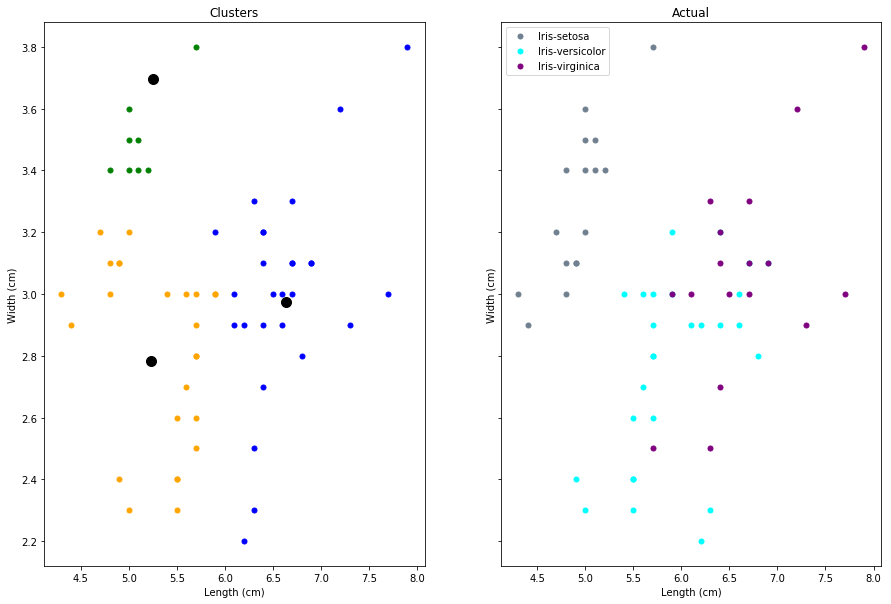

In [13]:
sepal_dat_test = test[['sepalLength', 'sepalWidth', 'Class']]

clusters = clusterData(sepal_dat_test, centroid)
plot(sepal_dat_test, centroid, clusters, "Sepal Length vs Width - Test")

In [14]:
petal_dat = train[['petalLength', 'petalWidth', 'Class']]

centroid = getCentroids(petal_dat)
clusters = clusterData(petal_dat, centroid)
# plot(petal_dat, centroid, clusters, "Petal Length vs Width - Train")

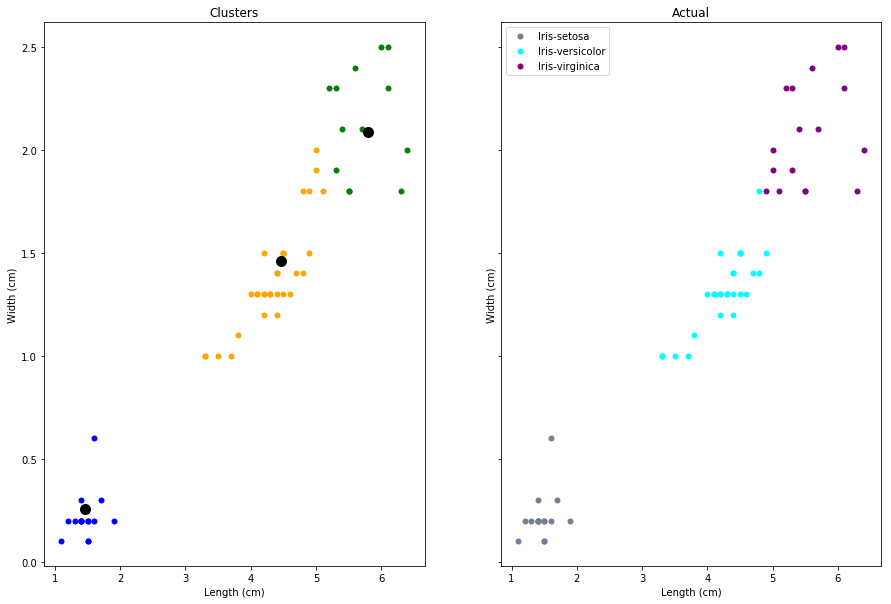

In [15]:
petal_dat_test = test[['petalLength', 'petalWidth', 'Class']]

clusters = clusterData(petal_dat_test, centroid)
plot(petal_dat_test, centroid, clusters, "Petal Length vs Width - Test")

# Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [17]:
treeClassifier = DecisionTreeClassifier()

In [18]:
def to_class(label):
    class_map = {
        'Iris-versicolor': 0,
        'Iris-virginica': 1, 
        'Iris-setosa': 2
    }
    
    return(class_map[label])

In [19]:
x = train.drop('Class', axis=1).values
y = train['Class'].apply(to_class).values

treeClassifier.fit(x, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
predictedData = treeClassifier.predict(test.drop('Class', axis=1).values)

## Accuracy of Decision Tree on test set

In [21]:
accuracy_score(test['Class'].apply(to_class).values, predictedData)*100

96.66666666666667